In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ee
import geemap
import geopandas as gpd
import contextily as ctx
from datetime import datetime, timedelta

In [ ]:
#Read the Lake geometry
gdf = gpd.read_file('Lake_Victoria_Shapefile.geojson')

In [ ]:
#Inspection
gdf.head()

,FID,Hylak_id,Lake_name,Country,Continent,Poly_src,Lake_type,Grand_id,Lake_area,Shore_len,...,Dis_avg,Res_time,Elevation,Slope_100,Wshd_area,Pour_long,Pour_lat,Shape__Area,Shape__Length,geometry
0,1,16,Victoria,Uganda,Africa,SWBD,3,4492,67166.22,7422.44,...,1735.515,18406.3,1134,-1,265372.8,33.193791,0.430999,6.735347e+10,7.450418e+06,"POLYGON ((31.91181 -2.72236, 31.91141 -2.72289..."


In [ ]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

/home/codespace/miniconda3/envs/H20/lib/python3.13/site-packages/contextily/tile.py:645: UserWarning: The inferred zoom level of 25 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


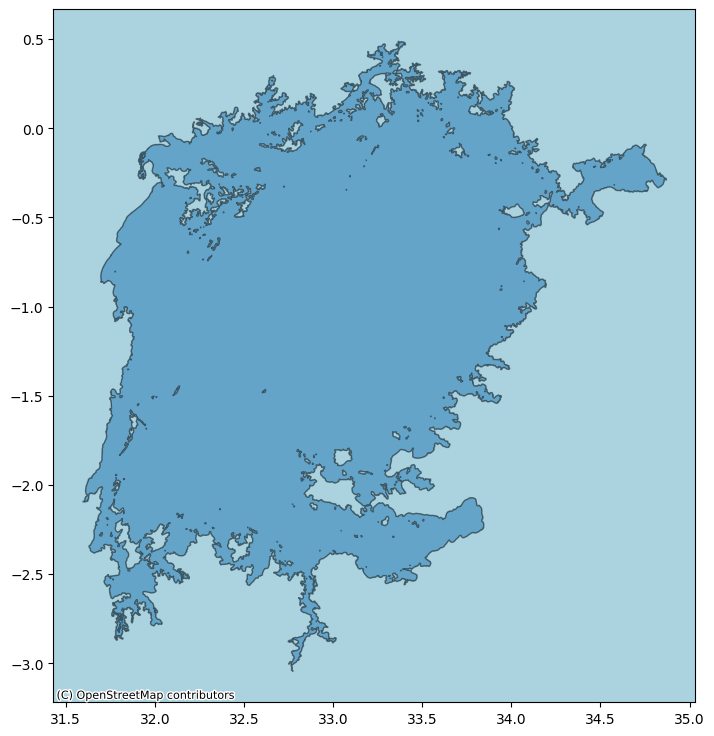

In [ ]:
#Use contextily
ax = gdf.to_crs(epsg=4326).plot(figsize=(9, 9), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

### Up to this point, we just inspected the file.

In [ ]:
#Authenticate with Earth Engine
ee.Authenticate()

True

In [ ]:
#Initialize
ee.Initialize()

In [ ]:
# Convert the geodataframe to ee object
lake_victoria = geemap.gdf_to_ee(gdf)

In [ ]:
#Create map
m = geemap.Map()
m

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
#add the lake as layer
m.addLayer(lake_victoria, {}, 'Lake Victoria')

In [ ]:
#Acquire Sentinel-2 data
def mask_s2_clouds(image):
  """Masks clouds in a Sentinel-2 image using the QA band.

  Args:
      image (ee.Image): A Sentinel-2 image.

  Returns:
      ee.Image: A cloud-masked Sentinel-2 image.
  """
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  )

  return image.updateMask(mask).divide(10000)


s2_dataset = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterDate('2017-03-28', '2024-11-08')
    # Pre-filter to get less cloudy granules.
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 5))
    .map(mask_s2_clouds)
)

visualization = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['B4', 'B3', 'B2'],
}
m.add_layer(s2_dataset.mean().clip(lake_victoria), visualization, 'RGB')

In [ ]:
# Function to get the dates
def get_dates(start_date, end_date):
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    dates = []
    while start + timedelta(days=1) <= end:
        dates.append([start.strftime('%Y-%m-%d'), (start + timedelta(days=1)).strftime('%Y-%m-%d')])
        start += timedelta(days=1)
    return dates

In [ ]:
def get_data(start_date, end_date, roi):
    # Sentinel-2 dataset
    dataset = ee.ImageCollection('COPERNICUS/S2_SR') \
        .filterBounds(roi) \
        .filterDate(start_date, end_date) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 5)) \
        .mean()

    # Dictionary to keep track of null values
    is_null = {
        'ndwi': False,
        'mndwi': False,
        'ndci': False,
        'ndti': False,
        'do': False,
        'ph': False,
        'chl_a': False,
        'ssc': False,
        'wst': False,
    }

    # NDWI
    try:
        ndwi_bands = ['B3', 'B5']
        ndwi = dataset.normalizedDifference(ndwi_bands).rename('ndwi')
        latlon = ee.Image.pixelLonLat().addBands(ndwi)
        latlon = latlon.reduceRegion(
            reducer=ee.Reducer.toList(),
            geometry=roi,
            scale=8
        )
        data_ndwi = np.array(ee.Array(latlon.get('ndwi')).getInfo())
    except:
        is_null["ndwi"] = True

    # MNDWI
    try:
        band_mndwi = ['B3', 'B6']
        mndwi = dataset.normalizedDifference(band_mndwi).rename('mndwi')
        latlon = ee.Image.pixelLonLat().addBands(mndwi)
        latlon = latlon.reduceRegion(
            reducer=ee.Reducer.toList(),
            geometry=roi,
            scale=8
        )
        data_mndwi = np.array(ee.Array(latlon.get('mndwi')).getInfo())
    except:
        is_null["mndwi"] = True

    # NDCI
    try:
        band_ndci = ['B4', 'B3']
        ndci = dataset.normalizedDifference(band_ndci).rename('ndci')
        latlon = ee.Image.pixelLonLat().addBands(ndci)
        latlon = latlon.reduceRegion(
            reducer=ee.Reducer.toList(),
            geometry=roi,
            scale=8
        )
        data_ndci = np.array(ee.Array(latlon.get('ndci')).getInfo())
    except:
        is_null["ndci"] = True

    # DO
    try:
        band_do = ['B8', 'B11']
        dissolvedoxygen = dataset.normalizedDifference(band_do).rename('do')
        latlon = ee.Image.pixelLonLat().addBands(dissolvedoxygen)
        latlon = latlon.reduceRegion(
            reducer=ee.Reducer.toList(),
            geometry=roi,  # Corrected from geometry=geometry
            scale=8
        )
        data_do = np.array(ee.Array(latlon.get('do')).getInfo())
    except:
        is_null["do"] = True

    # NDTI
    try:
        band_ndti = ['B5', 'B11']
        ndti = dataset.normalizedDifference(band_ndti).rename('ndti')
        latlon = ee.Image.pixelLonLat().addBands(ndti)
        latlon = latlon.reduceRegion(
            reducer=ee.Reducer.toList(),
            geometry=roi,
            scale=8
        )
        data_ndti = np.array(ee.Array(latlon.get('ndti')).getInfo())
    except:
        is_null["ndti"] = True

    # pH
    try:
        ph = ee.Image(8.339).subtract(ee.Image(0.827).multiply(
            dataset.select('B1').divide(dataset.select('B8')))).rename('ph')
        latlon = ee.Image.pixelLonLat().addBands(ph)
        latlon = latlon.reduceRegion(
            reducer=ee.Reducer.toList(),
            geometry=roi,
            scale=8
        )
        data_ph = np.array(ee.Array(latlon.get('ph')).getInfo())
    except:
        is_null["ph"] = True

    # Chlorophyll-a
    try:
        Rrs_red = dataset.select('B3').divide(0.1)
        Rrs_blue = dataset.select('B2').divide(0.1)
        chl_a = Rrs_red.divide(Rrs_blue).pow(2.72).multiply(10.8).rename('chl_a')
        latlon = ee.Image.pixelLonLat().addBands(chl_a)
        latlon = latlon.reduceRegion(
            reducer=ee.Reducer.toList(),
            geometry=roi,
            scale=8
        )
        data_chl_a = np.array(ee.Array(latlon.get('chl_a')).getInfo())
    except:
        is_null["chl_a"] = True

    # Suspended Sediment Concentration (SSC)
    try:
        ssc = ee.Image(0.0113).multiply(ndwi.pow(3)) \
            .subtract(ee.Image(0.0135).multiply(ndwi.pow(2))) \
            .add(ee.Image(0.0075).multiply(ndwi)) \
            .add(ee.Image(2.5823)).rename('ssc')
        latlon = ee.Image.pixelLonLat().addBands(ssc)
        latlon = latlon.reduceRegion(
            reducer=ee.Reducer.toList(),
            geometry=roi,
            scale=8
        )
        data_ssc = np.array(ee.Array(latlon.get('ssc')).getInfo())
    except:
        is_null["ssc"] = True

    # Water Surface Temperature (WST)
    try:
        tir1 = dataset.select('B10')  # 10.8-11.3 µm
        tir2 = dataset.select('B11')  # 11.5-12.5 µm
        kelvin = tir2.divide(10).add(273.15)
        lst = kelvin.divide(ee.Image(1).toFloat().divide(tir2.divide(14380).add(1).log()))
        emissivity = ee.Image(0.98)
        atm_corr = lst.multiply(0.99).add(0.11).multiply(emissivity).subtract(2.5)
        wst = atm_corr.subtract(273.15).rename('wst')
        latlon = ee.Image.pixelLonLat().addBands(wst)
        latlon = latlon.reduceRegion(
            reducer=ee.Reducer.toList(),
            geometry=roi,
            scale=8
        )
        data_wst = np.array(ee.Array(latlon.get('wst')).getInfo())
    except:
        is_null["wst"] = True

    # Adding data one by one
    our_data = {}

    if is_null["ndwi"]:
        our_data["ndwi"] = None
    else:
        our_data["ndwi"] = data_ndwi

    if is_null["mndwi"]:
        our_data["mndwi"] = None
    else:
        our_data["mndwi"] = data_mndwi

    if is_null["ndci"]:
        our_data["ndci"] = None
    else:
        our_data["ndci"] = data_ndci

    if is_null["ndti"]:
        our_data["ndti"] = None
    else:
        our_data["ndti"] = data_ndti

    if is_null["do"]:
        our_data["do"] = None
    else:
        our_data["do"] = data_do

    if is_null["ph"]:
        our_data["ph"] = None
    else:
        our_data["ph"] = data_ph

    if is_null["chl_a"]:
        our_data["chl_a"] = None
    else:
        our_data["chl_a"] = data_chl_a

    if is_null["ssc"]:
        our_data["ssc"] = None
    else:
        our_data["ssc"] = data_ssc

    if is_null["wst"]:
        our_data["wst"] = None
    else:
        our_data["wst"] = data_wst

    dataframe = pd.DataFrame(our_data)

    return dataframe

In [ ]:
def get_dataframe(start_date, end_date, polygon):
    df_data = pd.DataFrame()
    df_data["ndwi"] = []
    df_data["mndwi"] = []
    df_data["ndci"] = []
    df_data["ndti"] = []
    df_data["do"] = []
    df_data["ph"] = []
    df_data["chl_a"] = []
    df_data["ssc"] = []
    df_data["wst"] = []
    df_data["date"] = []

    dates = get_dates(start_date, end_date)

    for date in dates:
        try:
            df = get_data(date[0], date[1], polygon)
            means = {}
            for column in df.columns:
                try:
                    means[column] = [df[column].mean()]
                except:
                    means[column] = None
            means["date"] = [date[0]]
            mean_data = pd.DataFrame(means)
            df_data = pd.concat([df_data, mean_data])
        except:
            mean_data = {}
            mean_data["date"] = date[0]
            mean_data["ndwi"] = [None]
            mean_data["mndwi"] = [None]
            mean_data["ndci"] = [None]
            mean_data["ndti"] = [None]
            mean_data["do"] = [None]
            mean_data["ph"] = [None]
            mean_data["chl_a"] = [None]
            mean_data["ssc"] = [None]
            mean_data["wst"] = [None]
            final_mean = pd.DataFrame(mean_data)
            
            df_data = pd.concat([df_data, final_mean])
    
    return df_data

In [ ]:
#get the ee.geometry
geometry = lake_victoria.geometry()

In [ ]:
#Define our periods
start = '2017-03-28'
end = '2024-11-08'

In [ ]:
final_data = get_dataframe(start, end, geometry)